<a href="https://colab.research.google.com/github/Neha-Nayak/PySpark-1/blob/main/PySpark_ResultAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RESULT ANALYSIS



Analysis, Prediction and visualization of University marks data in Python using PySpark

In [2]:
#Clone the git repository 
#!git clone https://github.com/bitmos/PySpark.git

In [3]:
# Install Pyspark
!pip install pyspark

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 47.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=f49e372f53c904542f641aa0f46b3792a76ac804127162e7209824d2f683c4c4
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


#####Necessary imports

In [4]:
from pyspark.sql import SparkSession
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import col, when

#### Create a Spark Session

In [5]:
spark = SparkSession.builder.appName('Practise').getOrCreate()

#### Load the Result.csv file (Dataset) for Analysis

In [11]:
df = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/Results_Data.csv',header=True,inferSchema=True)
df.show()

+----------+--------+---+---+---+------+-----+-----+--------+
|       USN|   SCODE|CIE|SEE|TOT|RESULT|GRADE| DATE|ExamType|
+----------+--------+---+---+---+------+-----+-----+--------+
|4JN18CS001| 18MAT11| 32| 41| 73|     P|    8|12019| Regular|
|4JN18CS001| 18PHY12| 29| 47| 76|     P|    8|12019| Regular|
|4JN18CS001| 18ELE13| 25| 43| 68|     P|    7|12019| Regular|
|4JN18CS001| 18CIV14| 31| 26| 57|     P|    6|12019| Regular|
|4JN18CS001|18EGDL15| 31| 56| 87|     P|    9|12019| Regular|
|4JN18CS001|18PHYL16| 32| 40| 72|     P|    8|12019| Regular|
|4JN18CS001|18ELEL17| 34| 52| 86|     P|    9|12019| Regular|
|4JN18CS001| 18EGH18| 27| 32| 59|     P|    6|12019| Regular|
|4JN18CS002| 18MAT11| 33| 51| 84|     P|    9|12019| Regular|
|4JN18CS002| 18PHY12| 36| 45| 81|     P|    9|12019| Regular|
|4JN18CS002| 18ELE13| 37| 31| 68|     P|    7|12019| Regular|
|4JN18CS002| 18CIV14| 34| 29| 63|     P|    7|12019| Regular|
|4JN18CS002|18EGDL15| 34| 55| 89|     P|    9|12019| Regular|
|4JN18CS

### Objective 1: Students Performance in a Subject 
##### The objective is to visualize the student performance in a particular subject based on the total marks obtained. In a particular subject the average performance of students is visualized based on the total marks obtained. Enter the subject code to view the performance of all students in that subject.A bar graph is depicted for the number of students against total marks obtained in the given subject.

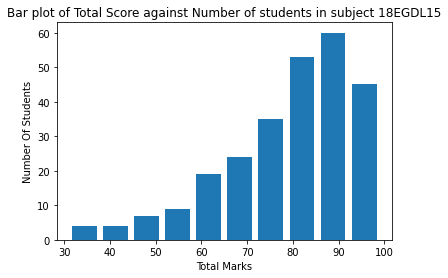

In [12]:
def subcode(subname):
    plt.title('Bar plot of Total Score against Number of students in subject '+str(subname))
    plt.xlabel('Total Marks')
    plt.ylabel('Number Of Students')
    df_BySub=df.filter(df.SCODE == subname)
    x=df_BySub.toPandas()["TOT"].values.tolist()
    plt.hist(x,rwidth=0.8)
    plt.show()
subcode("18EGDL15")

### Objective 2: Perfomance Prediction (Grade)
##### The objective is to predict the performance of a particular student based on the subject code. We use Machine Learning or MLib package in Pyspark to solve this. Subject Code, USN of the student and Year of the exam is given as input, the grade of that students in the subject in the next attempt is displayed.

In [18]:
#Preprocessing of data
import string
encoded1= {}
count =0
for i in string.ascii_uppercase:
    if i not in encoded1:
        encoded1[i]= count
    count = count +1

data_itr = df.rdd.toLocalIterator()
encoded = []

def replace_all1(text, encoded1):
    for i, j in encoded1.items():
        text = text.replace(i, str(j))
    return text

for i in data_itr:
    a =i['USN'] 
    b = i['SCODE']
    c = i['DATE']
    encoded.append({'USN1':a,'encodedUSN':int(replace_all1(a,encoded1)),'SCODE1':b,'DATE1':c})


dataframe = spark.createDataFrame(encoded)
new = df.join(dataframe,(df.USN ==  dataframe.USN1) & (df.SCODE ==dataframe.SCODE1) & (df.DATE == dataframe.DATE1))
new.createOrReplaceTempView("df2_view")


dffinal = spark.sql(
    """
    SELECT encodedUSN,GRADE,
    (CASE
    WHEN SCODE LIKE '%1' THEN 1
    WHEN SCODE LIKE '%2' THEN 2
    WHEN SCODE LIKE '%3' THEN 3
    WHEN SCODE LIKE '%4' THEN 4
    WHEN SCODE LIKE '%5' THEN 5
    WHEN SCODE LIKE '%6' THEN 6
    WHEN SCODE LIKE '%7' THEN 7
    WHEN SCODE LIKE '%8' THEN 8
    WHEN SCODE LIKE '%9' THEN 9
    END) AS SCODEFINAL,
    (CASE
    WHEN DATE LIKE '%19' THEN 19
    WHEN DATE LIKE '%20' THEN 20
    END) AS NEWDATE
    
    FROM df2_view
    """
)
featureassembler=VectorAssembler(inputCols=['encodedUSN','NEWDATE','SCODEFINAL'],outputCol="NEW")
output=featureassembler.transform(dffinal)

df2 = output.select('encodedUSN','NEW','GRADE')
limited = df2.limit(2400)

train, test = limited.randomSplit([0.9, 0.1])
#Linear Regression
lr=LinearRegression(featuresCol='NEW', labelCol='GRADE')
lrModel=lr.fit(train)

#Random Forest
rf = RandomForestClassifier(featuresCol = 'NEW', labelCol = 'GRADE')
rfModel = rf.fit(train)

dftest = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/new.csv',header=True,inferSchema=True)
dftest = dftest.limit(15000)

data_itr1 = dftest.rdd.toLocalIterator()
encoded3 = []

def replace_all1(text, encoded1):
    for i, j in encoded1.items():
        text = text.replace(i, str(j))
    return text

for i in data_itr1:
    a =i['USN'] 
    b = i['SCODE']
    c = i['GRADE']
    encoded3.append({'USN1':a,'encodedUSN':int(replace_all1(a,encoded1)),'SCODE1':b,'TOT1':c})

dataframe1 = spark.createDataFrame(encoded3)
new5 = dftest.join(dataframe1,(dftest.USN ==  dataframe1.USN1) & (dftest.SCODE ==dataframe1.SCODE1) )
new5.createOrReplaceTempView("df7_view")

dffinal7 = spark.sql(
    """
    SELECT USN,encodedUSN,GRADE,
    (CASE
    WHEN SCODE LIKE '%1' THEN 1
    WHEN SCODE LIKE '%2' THEN 2
    WHEN SCODE LIKE '%3' THEN 3
    WHEN SCODE LIKE '%4' THEN 4
    WHEN SCODE LIKE '%5' THEN 5
    WHEN SCODE LIKE '%6' THEN 6
    WHEN SCODE LIKE '%7' THEN 7
    WHEN SCODE LIKE '%8' THEN 8
    WHEN SCODE LIKE '%9' THEN 9
    END) AS SCODEFINAL,
    (CASE
    WHEN DATE LIKE '%19' THEN 19
    WHEN DATE LIKE '%21' THEN 21
    END) AS NEWDATE
    
    FROM df7_view
    """
)
featureassembler=VectorAssembler(inputCols=['encodedUSN','NEWDATE','SCODEFINAL'],outputCol="NEW")
output1=featureassembler.transform(dffinal7)
testfinal = output1.select('NEW','USN','encodedUSN','GRADE')
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))



Training Dataset Count: 2153
Test Dataset Count: 247


In [19]:
#Output of Linear Regression
predictions2 = lrModel.transform(testfinal)
predictions2.select(['encodedUSN','GRADE','prediction']).show(25)

+------------+-----+------------------+
|  encodedUSN|GRADE|        prediction|
+------------+-----+------------------+
|491318218001|    8| 6.781346004339866|
|491318218001|    8| 6.808439325017389|
|491318218001|    7|6.8355326456949115|
|491318218001|    6| 6.862625966372434|
|491318218001|    9| 6.889719287049957|
|491318218001|    8| 6.916812607727479|
|491318218001|    9| 6.943905928405002|
|491318218001|    6| 6.970999249140732|
|491318218002|    9| 6.781346710107755|
|491318218002|    9|6.8084400307852775|
|491318218002|    7|   6.8355333514628|
|491318218002|    7| 6.862626672140323|
|491318218002|    9| 6.889719992817845|
|491318218002|    8| 6.916813313495368|
|491318218002|    9|  6.94390663417289|
|491318218002|    8| 6.970999954908621|
|491318218003|    9|6.7813474158756435|
|491318218003|    8| 6.808440736553166|
|491318218003|    9| 6.835534057230689|
|491318218003|    8| 6.862627377908211|
|491318218003|    6| 6.889720698585734|
|491318218003|    6| 6.916814019263256|


In [20]:
#Output of Random Forest
predictions = rfModel.transform(testfinal)
predictions.select(['encodedUSN','GRADE','prediction']).show(25)


+------------+-----+----------+
|  encodedUSN|GRADE|prediction|
+------------+-----+----------+
|491318218001|    8|       9.0|
|491318218001|    8|       8.0|
|491318218001|    7|       7.0|
|491318218001|    6|       7.0|
|491318218001|    9|       9.0|
|491318218001|    8|       9.0|
|491318218001|    9|       9.0|
|491318218001|    6|       7.0|
|491318218002|    9|       9.0|
|491318218002|    9|       8.0|
|491318218002|    7|       7.0|
|491318218002|    7|       7.0|
|491318218002|    9|       9.0|
|491318218002|    8|       9.0|
|491318218002|    9|       9.0|
|491318218002|    8|       7.0|
|491318218003|    9|       9.0|
|491318218003|    8|       8.0|
|491318218003|    9|       7.0|
|491318218003|    8|       7.0|
|491318218003|    6|       9.0|
|491318218003|    6|       9.0|
|491318218003|    9|       9.0|
|491318218003|    8|       7.0|
|491318218004|    5|       9.0|
+------------+-----+----------+
only showing top 25 rows



### Objective 3: Backlog Analysis
##### The objective is to analyze whether a student with backlog has cleared the exam in the successive attempt. This analysis is done based on the Examtype specified in the dataset, if the examtype if specified as 'regular' then the subject has been cleared by the student. On providing the USN of a student, the subjects in which the student has a backlog is listed out, and the subjects which have been cleared in the successive attempt will be displayed. If the students has not cleared any backlogs, a message stating the same is displayed. If the student does not have any backlog then a message stating subjects have not been failed will be displayed.


In [15]:
#Filter the unnecessary Coloumns
df1=df.select('USN','SCODE','TOT','RESULT','ExamType')
#Drop null values
dftry=df1.na.drop(how='any',subset='ExamType')
#Select Students who failed Regular Exam
df2=dftry.filter((dftry.ExamType == 'Regular') & (dftry.RESULT == "F"))
#Function for determining whether a student has passed in the backlog exam.
def check_usn(usn):
  sub=[]
  flag=[]
  df2=dftry.filter((dftry.ExamType == 'Regular') & (dftry.RESULT == "F") & (dftry.USN == usn))
  df3=dftry.filter((dftry.ExamType == 'Backlog') & (dftry.RESULT == "P") & (dftry.USN == usn))
  for i in df2.select("SCODE").collect():
    sub.append(i['SCODE'])
    if i['SCODE'] in df3.toPandas()["SCODE"].values.tolist():
      flag.append(i['SCODE'])
  return sub,flag
output=check_usn("4JN18CS047")
subFail=output[0]
subPass=output[1]
#Output
print("Sujects Failed:", subFail)
print("Sujects Passed:", subPass)

Sujects Failed: ['18MAT11', '18ELE13', '18CIV14', '18EGDL15', '18PHYL16', '18MAT21', '18ELN24']
Sujects Passed: ['18CIV14']


### Objective 4: Pass or Fail Analysis
##### The objective is to visualize the number of students passed or failed in a particular subject. This analysis is done using the result specified in the dataset which can be either Pass(P) or Fail(F). A Bar graph is plotted using Matplotlib, a python library. The subject code is the input and the graph of that particular subject is shown.

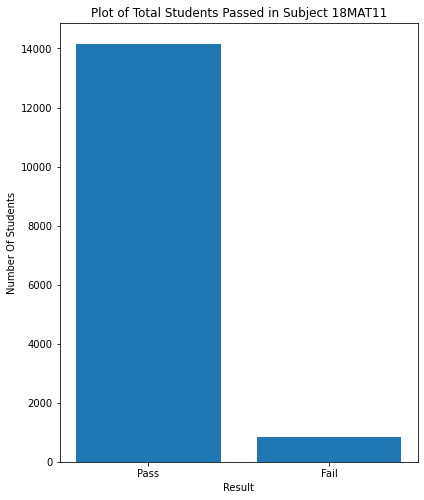

In [16]:
valueWhenTrue = "F"  # for example

df_ResultData=df.withColumn(
    "RESULT",
    when(
        col("RESULT") == 'A',
        valueWhenTrue
    ).otherwise(col("RESULT"))
)
x = ['Pass','Fail']
x_pos = [i for i, _ in enumerate(x)]
y=[df_ResultData.filter(df_ResultData.RESULT == "P").count(),df_ResultData.filter(df_ResultData.RESULT == "F").count()]
def subcode(subname):
    fig = plt.figure()
    plt.title('Plot of Total Students Passed in Subject '+ subname)
    plt.xlabel('Result')
    plt.ylabel('Number Of Students')
    plt.bar(x,y)
    plt.xticks(x_pos, x)
    plt.tight_layout()
    fig.set_figheight(8)
    fig.set_figwidth(6)
    plt.show()
subcode("18MAT11")

### Objective 5: Semester-wise Performance Analysis
##### The objective is to visualize the student performance based on a particular year or semester.The analysis is done by taking average of total marks obtained by a student in a particularsemester. A line chart is plotted to visualize the analysis made. Enter the students USN and performance graph of the same will be displayed.

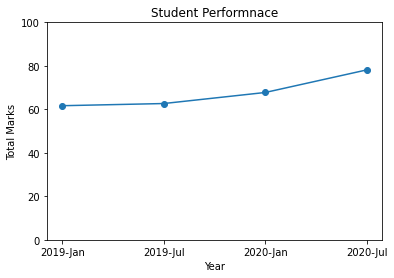

In [17]:
#Columns USN, DATE and TOTAL are formatted for our test case.
dfT = df.withColumn("DATE", when(df_ResultData.DATE == 'Jul-20','2020-Jul')
                                 .when(df_ResultData.DATE == '20-Jul','2020-Jul')
                                 .when(df_ResultData.DATE == 'Jan-20','2020-Jan')
                                 .when(df_ResultData.DATE == '12019','2019-Jan')
                                 .when(df_ResultData.DATE == '72019','2019-Jul')
                                 .when(df_ResultData.DATE == '12020','2020-Jan')
                                 .when(df_ResultData.DATE == '72020','2020-Jul'))
#Selecting a particular USN for whom the performance graph will be plotted
def filter(usn):
  dftry1=dfT.filter(dfT.USN == usn)
  return dftry1
def USN(usn):
      df_usn=filter(usn)
      df_data=df_usn.select('DATE','TOT')
      #Obtaining Average of Total marks for a student in a particulat semester.
      dfPlot1=df_data.groupBy("DATE").avg("TOT")
      dfPlot=dfPlot1.sort('DATE')
      #Line plot for Student performance, which determines the average of total marks obtained by the student in a particular semester.
      plt.title('Student Performnace')
      plt.xlabel('Year')
      plt.ylabel('Total Marks')
      x=dfPlot.toPandas()['DATE'].values.tolist()
      y=dfPlot.toPandas()['avg(TOT)'].values.tolist()
      plt.plot(x,y,marker = 'o')
      plt.ylim(0,100)
      plt.show()
#Input       
USN('4JN17CS010')

### Objective 6: Consecutive score prediction
##### The objective is to predict the score of a student in the consecutive semester based on the score of the similar subject in present or previous semesters. We use Machine Learning or MLib package in Pyspark to solve this. Subject Code, USN of the student and Year of the exam is given as input by the user, the total marks of that students in the specified subject in the next semester is displayed.

In [21]:
import string
encoded1= {}
count =0
for i in string.ascii_uppercase:
    if i not in encoded1:
        encoded1[i]= count
    count = count +1

data_itr = df.rdd.toLocalIterator()
encoded = []

def replace_all1(text, encoded1):
    for i, j in encoded1.items():
        text = text.replace(i, str(j))
    return text

for i in data_itr:
    a =i['USN'] 
    b = i['SCODE']
    c = i['DATE']
    encoded.append({'USN1':a,'encodedUSN':int(replace_all1(a,encoded1)),'SCODE1':b,'DATE1':c})


dataframe = spark.createDataFrame(encoded)
new = df.join(dataframe,(df.USN ==  dataframe.USN1) & (df.SCODE ==dataframe.SCODE1) & (df.DATE == dataframe.DATE1))
new.createOrReplaceTempView("df2_view")


dffinal = spark.sql(
    """
    SELECT encodedUSN,TOT,
    (CASE
    WHEN SCODE LIKE '%1' THEN 1
    WHEN SCODE LIKE '%2' THEN 2
    WHEN SCODE LIKE '%3' THEN 3
    WHEN SCODE LIKE '%4' THEN 4
    WHEN SCODE LIKE '%5' THEN 5
    WHEN SCODE LIKE '%6' THEN 6
    WHEN SCODE LIKE '%7' THEN 7
    WHEN SCODE LIKE '%8' THEN 8
    WHEN SCODE LIKE '%9' THEN 9
    END) AS SCODEFINAL,
    (CASE
    WHEN DATE LIKE '%19' THEN 19
    WHEN DATE LIKE '%20' THEN 20
    END) AS NEWDATE
    
    FROM df2_view
    """
)
featureassembler=VectorAssembler(inputCols=['encodedUSN','NEWDATE','SCODEFINAL'],outputCol="NEW")
output=featureassembler.transform(dffinal)

df2 = output.select('encodedUSN','NEW','TOT')
limited = df2.limit(1050)

train, test = limited.randomSplit([0.9, 0.1])

lr=LinearRegression(featuresCol='NEW', labelCol='TOT')
lrModel=lr.fit(train)

rf = RandomForestClassifier(featuresCol = 'NEW', labelCol = 'TOT')
rfModel = rf.fit(train)

dftest = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/new1.csv',header=True,inferSchema=True)
dftest = dftest.limit(15000)

data_itr1 = dftest.rdd.toLocalIterator()
encoded3 = []

def replace_all1(text, encoded1):
    for i, j in encoded1.items():
        text = text.replace(i, str(j))
    return text

for i in data_itr1:
    a =i['USN'] 
    b = i['SCODE']
    c = i['TOT']
    encoded3.append({'USN1':a,'encodedUSN':int(replace_all1(a,encoded1)),'SCODE1':b,'TOT1':c})

dataframe1 = spark.createDataFrame(encoded3)
new5 = dftest.join(dataframe1,(dftest.USN ==  dataframe1.USN1) & (dftest.SCODE ==dataframe1.SCODE1) )
new5.createOrReplaceTempView("df7_view")

dffinal7 = spark.sql(
    """
    SELECT USN,encodedUSN,TOT,
    (CASE
    WHEN SCODE LIKE '%1' THEN 1
    WHEN SCODE LIKE '%2' THEN 2
    WHEN SCODE LIKE '%3' THEN 3
    WHEN SCODE LIKE '%4' THEN 4
    WHEN SCODE LIKE '%5' THEN 5
    WHEN SCODE LIKE '%6' THEN 6
    WHEN SCODE LIKE '%7' THEN 7
    WHEN SCODE LIKE '%8' THEN 8
    WHEN SCODE LIKE '%9' THEN 9
    END) AS SCODEFINAL,
    (CASE
    WHEN DATE LIKE '%19' THEN 19
    WHEN DATE LIKE '%21' THEN 21
    END) AS NEWDATE
    
    FROM df7_view
    """
)
featureassembler=VectorAssembler(inputCols=['encodedUSN','NEWDATE','SCODEFINAL'],outputCol="NEW")
output1=featureassembler.transform(dffinal7)
testfinal = output1.select('NEW','USN','encodedUSN','TOT')

In [22]:
#Output of Linear Regression
predictions2 = lrModel.transform(testfinal)
predictions2.select(['encodedUSN','TOT','prediction']).show(25)

+------------+---+-----------------+
|  encodedUSN|TOT|       prediction|
+------------+---+-----------------+
|491318218001| 73|67.32382491137832|
|491318218001| 76| 68.2974499957636|
|491318218001| 68| 69.2710750810802|
|491318218001| 57| 70.2447001663968|
|491318218001| 87|71.21832525078207|
|491318218001| 72|72.19195033609867|
|491318218001| 86|73.16557542141527|
|491318218001| 59|74.13920050580055|
|491318218002| 84|67.32383823208511|
|491318218002| 81|68.29746331647038|
|491318218002| 68|69.27108840178698|
|491318218002| 63|70.24471348710358|
|491318218002| 89|71.21833857148886|
|491318218002| 75|72.19196365680546|
|491318218002| 84|73.16558874212205|
|491318218002| 72|74.13921382650733|
|491318218003| 81|67.32385155186057|
|491318218003| 73|68.29747663624585|
|491318218003| 81|69.27110172156245|
|491318218003| 72|70.24472680687904|
|491318218003| 57|71.21835189126432|
|491318218003| 57|72.19197697658092|
|491318218003| 83|73.16560206189752|
|491318218003| 75|74.13922714628279|
|

In [23]:
#Output of Random Forest
predictions = rfModel.transform(testfinal)
predictions.select(['encodedUSN','TOT','prediction']).show(25)

+------------+---+----------+
|  encodedUSN|TOT|prediction|
+------------+---+----------+
|491318218001| 73|      73.0|
|491318218001| 76|      73.0|
|491318218001| 68|      68.0|
|491318218001| 57|      63.0|
|491318218001| 87|      87.0|
|491318218001| 72|      87.0|
|491318218001| 86|      83.0|
|491318218001| 59|      72.0|
|491318218002| 84|      73.0|
|491318218002| 81|      73.0|
|491318218002| 68|      68.0|
|491318218002| 63|      63.0|
|491318218002| 89|      87.0|
|491318218002| 75|      87.0|
|491318218002| 84|      83.0|
|491318218002| 72|      72.0|
|491318218003| 81|      73.0|
|491318218003| 73|      73.0|
|491318218003| 81|      68.0|
|491318218003| 72|      63.0|
|491318218003| 57|      87.0|
|491318218003| 57|      87.0|
|491318218003| 83|      83.0|
|491318218003| 75|      72.0|
|491318218004| 46|      73.0|
+------------+---+----------+
only showing top 25 rows

